In [1]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [32]:
hist = pd.read_csv('./../datasets/prod-region.csv', sep=';')
hist.head(1000)

D:\anaconda3\envs\v-env\lib\site-packages\IPython\core\interactiveshell.py:3417: DtypeWarning: Columns (13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Horodate,Région,Code région,Plage de puissance injection,Filière de production,Nb points injection,Total énergie injectée (Wh),Courbe Moyenne n°1 (Wh),Indice représentativité Courbe n°1 (%),Courbe Moyenne n°2 (Wh),Indice représentativité Courbe n°2 (%),Courbe Moyenne n°1 + n°2 (Wh),Indice représentativité Courbe n°1 + n°2 (%),Jour max du mois (0/1),Semaine max du mois (0/1)
0,2021-12-31T23:30:00+01:00,Nouvelle Aquitaine,75,P3 : ]9 - 100] kW,F5 : Solaire,6625,0.0,NaN,S,NaN,S,NaN,S,S,S
1,2021-12-31T23:30:00+01:00,Nouvelle Aquitaine,75,P6 : ]1000 - 12000] kW,F5 : Solaire,272,0.0,0.0,49,0.0,50,0.0,99,0,0
2,2021-12-31T23:30:00+01:00,Nouvelle Aquitaine,75,P2 : ]3 - 9] kW,F5 : Solaire,18491,0.0,NaN,S,NaN,S,NaN,S,S,S
3,2021-12-31T23:30:00+01:00,Nouvelle Aquitaine,75,P4 : ]100 - 250] kW,F5 : Solaire,1379,0.0,0.0,49,0.0,50,0.0,100,0,0
4,2021-12-31T23:30:00+01:00,Nouvelle Aquitaine,75,P7 : > 12000 kW,F5 : Solaire,14,0.0,0.0,50,0.0,50,0.0,100,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2021-12-29T09:30:00+01:00,Nouvelle Aquitaine,75,P3 : ]9 - 100] kW,F5 : Solaire,6608,7712994.0,NaN,S,NaN,S,NaN,S,S,S
996,2021-12-29T09:30:00+01:00,Nouvelle Aquitaine,75,P1 : ]0 - 3] kW,F5 : Solaire,42924,1273208.0,NaN,S,NaN,S,NaN,S,S,S
997,2021-12-29T09:30:00+01:00,Nouvelle Aquitaine,75,P4 : ]100 - 250] kW,F5 : Solaire,1378,2583480.0,2130.0,49,1529.0,50,1828.0,100,0,0
998,2021-12-29T09:30:00+01:00,Nouvelle Aquitaine,75,P7 : > 12000 kW,F5 : Solaire,14,2719000.0,268166.0,50,120261.0,50,194214.0,100,0,0


In [33]:
#reduce information
hist.drop(['Région', 'Code région', 'Plage de puissance injection', 'Filière de production', 'Nb points injection',
         'Total énergie injectée (Wh)', 'Courbe Moyenne n°1 (Wh)', 'Indice représentativité Courbe n°1 (%)',
         'Courbe Moyenne n°2 (Wh)', 'Indice représentativité Courbe n°2 (%)',
         'Indice représentativité Courbe n°1 + n°2 (%)', 'Jour max du mois (0/1)', 'Semaine max du mois (0/1)'],
        axis='columns', inplace=True)
hist.dropna(inplace=True)
hist['Horodate'] = pd.to_datetime(hist['Horodate'].values, utc=True)
hist['Horodate'] = hist['Horodate'].dt.tz_localize(None)
hist = hist.loc[hist['Horodate'] > '2020-06-01']
hist.head(100)

,Horodate,Courbe Moyenne n°1 + n°2 (Wh)
1,2021-12-31 22:30:00,0.0
3,2021-12-31 22:30:00,0.0
4,2021-12-31 22:30:00,0.0
5,2021-12-31 22:30:00,0.0
10,2021-12-31 22:00:00,0.0
...,...,...
230,2021-12-31 08:30:00,29789.0
231,2021-12-31 08:30:00,392695.0
234,2021-12-31 08:00:00,6562.0
236,2021-12-31 08:00:00,398285.0


In [34]:
hist = hist.groupby('Horodate').sum()
target_col = 'Courbe Moyenne n°1 + n°2 (Wh)'
hist.head(1000)

,Courbe Moyenne n°1 + n°2 (Wh)
Horodate,
2020-06-01 00:30:00,0.0
2020-06-01 01:00:00,0.0
2020-06-01 01:30:00,0.0
2020-06-01 02:00:00,0.0
2020-06-01 02:30:00,0.0
...,...
2020-06-21 18:00:00,263725.0
2020-06-21 18:30:00,129105.0
2020-06-21 19:00:00,43523.0


In [35]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [36]:
train, test = train_test_split(hist, test_size=0.05)

In [37]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('Production [Wh]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)

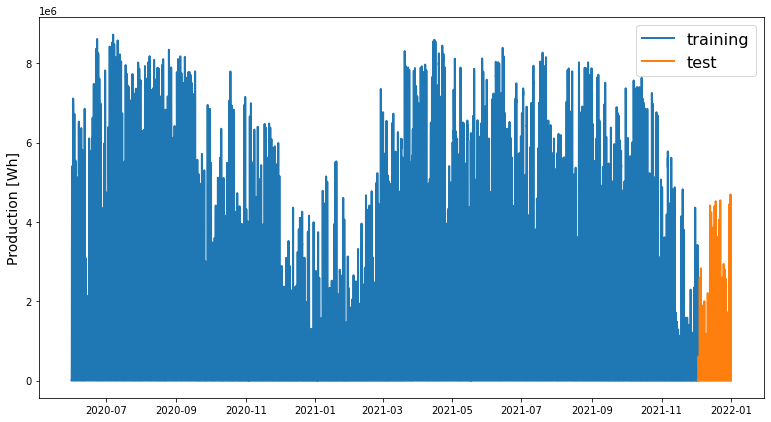

In [38]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [39]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (df.max() - df.min())

In [40]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [41]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [82]:
def build_lstm_model(input_data, output_size, neurons=128, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    #model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(LSTM(neurons, return_sequences=True, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))

    model.add(LSTM(neurons//2, return_sequences=True, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))

    model.add(LSTM(neurons//2, return_sequences=True, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))

    model.add(LSTM(neurons//2, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))

    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [83]:
np.random.seed(42)
#window_len = 5
window_len = 24
test_size = 0.2
zero_base = False
lstm_neurons = 100
epochs = 100
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [84]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [85]:
X_train

array([[[      0.],
        [      0.],
        [      0.],
        ...,
        [3380859.],
        [2772143.],
        [1865631.]],

       [[      0.],
        [      0.],
        [      0.],
        ...,
        [2772143.],
        [1865631.],
        [1926614.]],

       [[      0.],
        [      0.],
        [      0.],
        ...,
        [1865631.],
        [1926614.],
        [4226243.]],

       ...,

       [[7679506.],
        [7590662.],
        [7379783.],
        ...,
        [      0.],
        [      0.],
        [      0.]],

       [[7590662.],
        [7379783.],
        [7051297.],
        ...,
        [      0.],
        [      0.],
        [      0.]],

       [[7379783.],
        [7051297.],
        [6665193.],
        ...,
        [      0.],
        [      0.],
        [      0.]]])

In [86]:
%%time
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_path = 'model1.hdf5'

checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

earlystopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

callbacks = [ checkpoint, earlystopping ]

history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True, callbacks=callbacks)

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
693/694 [============================>.] - ETA: 0s - loss: 8025351913472.0000WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001E885886708> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full 

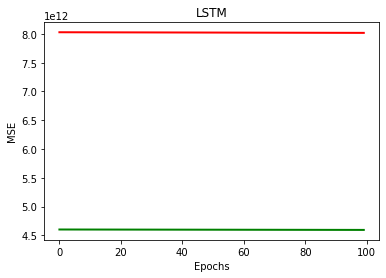

In [87]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [88]:
targets = test[target_col][window_len:]
predictions = model.predict(X_test)
print(predictions)
preds = predictions.squeeze()
mean_absolute_error(preds, y_test)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
[[3408.237]
 [3408.237]
 [3408.237]
 ...
 [3408.237]
 [3408.237]
 [3408.237]]


1077913.1180619032

In [89]:
from sklearn.metrics import mean_squared_error
MAE=mean_squared_error(preds, y_test)
MAE

4593742205353.059

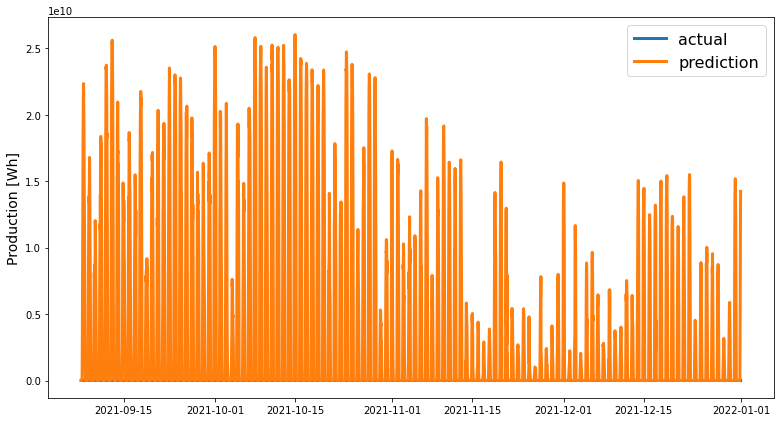

In [90]:
preds = test[target_col].values[:-window_len] * (preds + 1)
predicted_btc_price_test_data = preds
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

In [91]:
X_ = y_test[-window_len:]
X_ = X_.reshape(1, window_len, 1)
X_

array([[[4.482502e+06],
        [4.639636e+06],
        [4.693417e+06],
        [4.625511e+06],
        [4.408721e+06],
        [4.154922e+06],
        [3.618560e+06],
        [2.723181e+06],
        [1.718660e+06],
        [7.709230e+05],
        [1.565650e+05],
        [4.821000e+03],
        [3.000000e+00],
        [1.000000e+00],
        [0.000000e+00],
        [1.000000e+00],
        [0.000000e+00],
        [2.000000e+00],
        [1.000000e+00],
        [0.000000e+00],
        [1.000000e+00],
        [0.000000e+00],
        [0.000000e+00],
        [0.000000e+00]]])

In [92]:
Y_ = model.predict(X_).reshape(-1, 1)
Y_

array([[3408.237]], dtype=float32)

In [95]:
# organize the results in a data frame
df_past = hist[[target_col]].reset_index()
df_past.rename(columns={'Horodate': 'Date', target_col: 'Actual'}, inplace=True)
df_past['Date'] = pd.to_datetime(df_past['Date'])
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]

df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=90)
df_future['Forecast'] = Y_.flatten()
df_future['Actual'] = np.nan

results = df_past.append(df_future).set_index('Date')

# plot the results
results.plot(title='Prod')

D:\anaconda3\envs\v-env\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


ValueError: Length of values (1) does not match length of index (90)

In [96]:
df_past

,Date,Actual,Forecast
0,2020-06-01 00:30:00,0.0,NaN
1,2020-06-01 01:00:00,0.0,NaN
2,2020-06-01 01:30:00,0.0,NaN
3,2020-06-01 02:00:00,0.0,NaN
4,2020-06-01 02:30:00,0.0,NaN
...,...,...,...
27767,2021-12-31 20:30:00,0.0,NaN
27768,2021-12-31 21:00:00,1.0,NaN
27769,2021-12-31 21:30:00,0.0,NaN
27770,2021-12-31 22:00:00,0.0,NaN


Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
867/867 [==============================] - 22s 22ms/step - loss: 0.0274
Epoch 2/100
867/867 [==============================] - 19s 22ms/step - loss: 0.0208
Epoch 3/100
867/867 [==============================] - 19s 22ms/step - loss: 0.0195
Epoch 4/100
867/867 [==============================] - 19s 22ms/step - loss: 0.0188
Epoch 5/100
867/867 [==============================] - 20s

<AxesSubplot:title={'center':'PROD'}, xlabel='Date'>

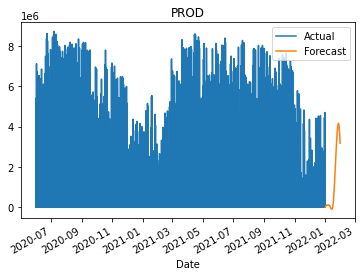

In [98]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# download the data
y = hist['Courbe Moyenne n°1 + n°2 (Wh)'].fillna(method='ffill')
y = y.values.reshape(-1, 1)

# scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(y)
y = scaler.transform(y)

# generate the input and output sequences
n_lookback = 24  # length of input sequences (lookback period)
n_forecast = 30  # length of output sequences (forecast period)

X = []
Y = []

for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback: i])
    Y.append(y[i: i + n_forecast])

X = np.array(X)
Y = np.array(Y)

# fit the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(units=50))
model.add(Dense(n_forecast))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X, Y, epochs=100, batch_size=32, verbose=1)

# generate the forecasts
X_ = y[- n_lookback:]  # last available input sequence
X_ = X_.reshape(1, n_lookback, 1)

Y_ = model.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_)

# organize the results in a data frame
df_past = hist[['Courbe Moyenne n°1 + n°2 (Wh)']].reset_index()
df_past.rename(columns={'Horodate': 'Date', 'Courbe Moyenne n°1 + n°2 (Wh)': 'Actual'}, inplace=True)
df_past['Date'] = pd.to_datetime(df_past['Date'])
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]

df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n_forecast)
df_future['Forecast'] = Y_.flatten()
df_future['Actual'] = np.nan

results = df_past.append(df_future).set_index('Date')

# plot the results
results.plot(title='PROD')

<AxesSubplot:title={'center':'PROD'}, xlabel='Date'>

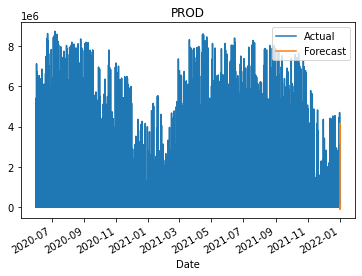

In [104]:
# generate the forecasts
X_ = y[- n_lookback:]  # last available input sequence
X_ = X_.reshape(1, n_lookback, 1)

Y_ = model.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_)

# organize the results in a data frame
df_past = hist[['Courbe Moyenne n°1 + n°2 (Wh)']].reset_index()
df_past.rename(columns={'Horodate': 'Date', 'Courbe Moyenne n°1 + n°2 (Wh)': 'Actual'}, inplace=True)
df_past['Date'] = pd.to_datetime(df_past['Date'])
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]

df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(minutes=30), periods=n_forecast, freq='30min')
df_future['Forecast'] = Y_.flatten()
df_future['Actual'] = np.nan

results = df_past.append(df_future).set_index('Date')

# plot the results
results.plot(title='PROD')

In [105]:
df_future

,Date,Actual,Forecast
0,2021-12-31 23:00:00,NaN,2.532345e+04
1,2021-12-31 23:30:00,NaN,9.147581e+04
2,2022-01-01 00:00:00,NaN,9.545509e+04
3,2022-01-01 00:30:00,NaN,1.131914e+05
4,2022-01-01 01:00:00,NaN,9.285348e+04
5,2022-01-01 01:30:00,NaN,8.572747e+04
6,2022-01-01 02:00:00,NaN,1.119997e+05
7,2022-01-01 02:30:00,NaN,1.038690e+05
8,2022-01-01 03:00:00,NaN,6.769652e+04
9,2022-01-01 03:30:00,NaN,2.120288e+04


In [ ]:
# Create a function that given an array of number and a number, return the closest number within the array

